In [159]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from mido import Message, MidiFile, MidiTrack
from mir_eval.util import hz_to_midi

In [2]:
weight = torch.load('./multirun/2022-09-03/12-18-11/2/ClassifierFreeDiffRoll-L15-C512-beta0.02-x_0-cfdg_ddpm_x0-w=0.1-p=0.35-MAESTRO/version_1/checkpoints/last.ckpt')

In [3]:
weight['state_dict'].keys()

odict_keys(['input_projection.weight', 'input_projection.bias', 'diffusion_embedding.projection1.weight', 'diffusion_embedding.projection1.bias', 'diffusion_embedding.projection2.weight', 'diffusion_embedding.projection2.bias', 'residual_layers.0.dilated_conv.weight', 'residual_layers.0.dilated_conv.bias', 'residual_layers.0.diffusion_projection.weight', 'residual_layers.0.diffusion_projection.bias', 'residual_layers.0.conditioner_projection.weight', 'residual_layers.0.conditioner_projection.bias', 'residual_layers.0.output_projection.weight', 'residual_layers.0.output_projection.bias', 'residual_layers.1.dilated_conv.weight', 'residual_layers.1.dilated_conv.bias', 'residual_layers.1.diffusion_projection.weight', 'residual_layers.1.diffusion_projection.bias', 'residual_layers.1.conditioner_projection.weight', 'residual_layers.1.conditioner_projection.bias', 'residual_layers.1.output_projection.weight', 'residual_layers.1.output_projection.bias', 'residual_layers.2.dilated_conv.weight',

In [4]:
weight['state_dict']['residual_layers']

KeyError: 'residual_layers'

In [6]:
noise_list = torch.load('outputs/2022-09-01/16-03-31/noise_list.pt')

In [7]:
noise_list[-1][0].shape

(4, 1, 640, 88)

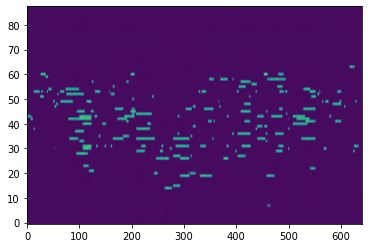

In [8]:
plt.imshow(noise_list[-1][0][0][0].T, aspect='auto', origin='lower')

In [9]:
noise_list[-1][0][0][0].max()

1.534282

In [10]:
def postprocess_probabilities_to_midi_events(output_dict):
    # TODO refactor classes_num, post_processor
    r"""Postprocess probabilities to MIDI events using thresholds.
    Args:
        output_dict, dict: e.g., {
            'frame_output': (N, 88*5),
            'reg_onset_output': (N, 88*5),
            ...}
    Returns:
        midi_events: dict, e.g.,
            {'0': [
                ['onset_time': 130.24, 'offset_time': 130.25, 'midi_note': 33, 'velocity': 100],
                ['onset_time': 142.77, 'offset_time': 142.78, 'midi_note': 33, 'velocity': 100],
                ...]
             'percussion': [
                ['onset_time': 6.57, 'offset_time': 6.70, 'midi_note': 36, 'velocity': 100],
                ['onset_time': 8.13, 'offset_time': 8.29, 'midi_note': 36, 'velocity': 100],
                ...],
             ...}
    """
    midi_events = {}
    for k, plugin_name in enumerate(plugin_ids):
        plugin_name = IX_TO_NAME[plugin_name.item()]        
#         print('Processing plugin_name: {}'.format(plugin_name), end='\r')

        if plugin_name == 'percussion':
            (est_note_events, est_pedal_events) = post_processor.output_dict_to_midi_events(
                plugins_output_dict[plugin_name],
                detect_type='percussion',
            )

        else:
            (est_note_events, est_pedal_events) = post_processor.output_dict_to_midi_events(
                plugins_output_dict[plugin_name],
                detect_type='piano',
            )
        midi_events[plugin_name] = est_note_events
    return midi_events


In [131]:
def extract_notes_wo_velocity_torch(onsets, frames, onset_threshold=0.5, frame_threshold=0.5, rule='rule1'):
    """
    Finds the note timings based on the onsets and frames information
    Parameters
    ----------
    onsets: torch.FloatTensor, shape = [frames, bins]
    frames: torch.FloatTensor, shape = [frames, bins]
    velocity: torch.FloatTensor, shape = [frames, bins]
    onset_threshold: float
    frame_threshold: float
    Returns
    -------
    pitches: np.ndarray of bin_indices
    intervals: np.ndarray of rows containing (onset_index, offset_index)
    velocities: np.ndarray of velocity values
    """
    onsets = (onsets > onset_threshold).long()
    frames = (frames > frame_threshold).long()
    onset_diff = torch.cat([onsets[:1, :], onsets[1:, :] - onsets[:-1, :]], dim=0) == 1 # Make sure the activation is only 1 time-step
    
    if rule=='rule2':
        pass
    elif rule=='rule1':
        # Use in simple models
        onset_diff = onset_diff & (frames==1) # New condition such that both onset and frame on to get a note
    else:
        raise NameError('Please enter the correct rule name')

    pitches = []
    intervals = []

    for nonzero in torch.nonzero(onset_diff):
        frame = nonzero[0].item()
        pitch = nonzero[1].item()

        onset = frame
        offset = frame

        # This while loop is looking for where does the note ends
        while onsets[offset, pitch] or frames[offset, pitch]:
            offset += 1
            if offset == onsets.shape[0]:
                break

        # After knowing where does the note start and end, we can return the pitch information (and velocity)        
        if offset > onset:
            pitches.append(pitch)
            intervals.append([onset, offset])

    return pitches, intervals




In [196]:
def extract_notes_wo_velocity(onsets, frames, onset_threshold=0.5, frame_threshold=0.5, rule='rule1'):
    """
    Finds the note timings based on the onsets and frames information
    Parameters
    ----------
    onsets: torch.FloatTensor, shape = [frames, bins]
    frames: torch.FloatTensor, shape = [frames, bins]
    velocity: torch.FloatTensor, shape = [frames, bins]
    onset_threshold: float
    frame_threshold: float
    Returns
    -------
    pitches: np.ndarray of bin_indices
    intervals: np.ndarray of rows containing (onset_index, offset_index)
    velocities: np.ndarray of velocity values
    """
    onsets = (onsets > onset_threshold).astype(int)
    frames = (frames > frame_threshold).astype(int)
    onset_diff = np.concatenate([onsets[:1, :], onsets[1:, :] - onsets[:-1, :]], axis=0) == 1 # Make sure the activation is only 1 time-step
    
    if rule=='rule2':
        pass
    elif rule=='rule1':
        # Use in simple models
        onset_diff = onset_diff & (frames==1) # New condition such that both onset and frame on to get a note
    else:
        raise NameError('Please enter the correct rule name')

    pitches = []
    intervals = []
    
    frame_locs, pitch_locs = np.nonzero(onset_diff)
    for frame, pitch in zip(frame_locs, pitch_locs):

        onset = frame
        offset = frame

        # This while loop is looking for where does the note ends
        while onsets[offset, pitch] or frames[offset, pitch]:
            offset += 1
            if offset == onsets.shape[0]:
                break

        # After knowing where does the note start and end, we can return the pitch information (and velocity)        
        if offset > onset:
            pitches.append(pitch)
            intervals.append([onset, offset])

    return np.array(pitches), np.array(intervals)

def save_midi(path, pitches, intervals, velocities):
    """
    Save extracted notes as a MIDI file
    Parameters
    ----------
    path: the path to save the MIDI file
    pitches: np.ndarray of bin_indices
    intervals: list of (onset_index, offset_index)
    velocities: list of velocity values
    """
    file = MidiFile()
    track = MidiTrack()
    file.tracks.append(track)
    ticks_per_second = file.ticks_per_beat * 2.0

    events = []
    for i in range(len(pitches)):
        events.append(dict(type='on', pitch=pitches[i], time=intervals[i][0], velocity=velocities[i]))
        events.append(dict(type='off', pitch=pitches[i], time=intervals[i][1], velocity=velocities[i]))
    events.sort(key=lambda row: row['time'])

    last_tick = 0
    for event in events:
        current_tick = int(event['time'] * ticks_per_second)
        velocity = int(event['velocity'] * 127)
        if velocity > 127:
            velocity = 127
        print(hz_to_midi(event['pitch']))
        pitch = int(round(hz_to_midi(event['pitch'])))
        track.append(Message('note_' + event['type'], note=pitch, velocity=velocity, time=current_tick - last_tick))
        last_tick = current_tick

    file.save(path)

In [247]:
noise_list[-1][]

AttributeError: 'tuple' object has no attribute 'shape'

In [248]:
torch_frame = torch.from_numpy(noise_list[-1][0][0][0])
np_frame = noise_list[-1][0][1][0]
p_est, i_est = extract_notes_wo_velocity(np_frame, np_frame)
torch_output = extract_notes_wo_velocity_torch(torch_frame, torch_frame)

HOP_LENGTH = 160

SAMPLE_RATE = 16000

from mir_eval.util import midi_to_hz
import os

MIN_MIDI = 21
MAX_MIDI = 108





scaling = HOP_LENGTH / SAMPLE_RATE

# Converting time steps to seconds and midi number to frequency
i_est = (i_est * scaling).reshape(-1, 2)
p_est = np.array([midi_to_hz(MIN_MIDI + midi) for midi in p_est])

clean_notes = (i_est[:,1]-i_est[:,0]>0.05)

midi_path = os.path.join('./', 'midi.mid')
print(f'midi_path = {midi_path}')
save_midi(midi_path, p_est[clean_notes], i_est[clean_notes], [127]*len(p_est))

midi_path = ./midi.mid
60.999999999999986
60.999999999999986
96.99999999999999
72.99999999999999
96.99999999999999
72.99999999999999
57.0
60.999999999999986
57.0
63.999999999999986
60.999999999999986
63.999999999999986
58.99999999999999
58.99999999999999
78.99999999999999
78.99999999999999
40.99999999999999
78.99999999999999
52.99999999999999
75.99999999999999
52.0
63.999999999999986
72.0
78.99999999999999
52.99999999999999
75.99999999999999
52.0
63.999999999999986
40.99999999999999
72.0
55.0
60.0
63.999999999999986
72.0
48.0
55.0
63.999999999999986
48.0
60.0
72.0
43.99999999999999
58.99999999999999
70.0
65.0
63.0
58.99999999999999
70.0
63.0
72.99999999999999
60.999999999999986
43.99999999999999
68.0
77.0
49.0
37.0
72.99999999999999
37.0
72.99999999999999
65.0
49.0
69.0
72.99999999999999
77.0
68.0
60.999999999999986
58.0
69.0
52.0
37.99999999999999
58.0
37.99999999999999
78.0
52.0
78.0
61.99999999999999
81.0
61.99999999999999
66.99999999999999
72.0
81.0
60.0
74.0
66.99999999999999
60.0